In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp")

S = 512

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * B[k, j])

    return [C]

mmul = tf.program(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 2
  Intermediate buffers: 5
  Lines of generated code: 114
  IR size: 53



In [2]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[128.67128  124.44226  132.0937   ... 128.31694  138.0139   126.517296]
 [123.94336  126.70417  132.59491  ... 128.65152  131.76201  126.21126 ]
 [122.70171  128.62915  131.03276  ... 126.3736   128.09308  126.4799  ]
 ...
 [127.465744 127.136314 136.00429  ... 123.10998  131.95026  128.98705 ]
 [132.35518  134.63278  135.6134   ... 131.91655  138.0433   134.6153  ]
 [124.94647  125.61793  136.68102  ... 130.01953  133.93108  125.34383 ]]
[[128.67134  124.44229  132.09366  ... 128.31696  138.01395  126.51721 ]
 [123.9434   126.704216 132.59494  ... 128.65146  131.76202  126.211235]
 [122.70167  128.62918  131.03275  ... 126.3736   128.09311  126.47987 ]
 ...
 [127.46576  127.13632  136.00429  ... 123.10994  131.95029  128.98705 ]
 [132.35524  134.63284  135.61343  ... 131.91647  138.0433   134.61533 ]
 [124.94647  125.61799  136.68103  ... 130.01956  133.93105  125.343796]]
[[-6.1035156e-05 -3.0517578e-05  4.5776367e-05 ... -1.5258789e-05
  -4.5776367e-05  8.3923340e-05]
 [-3.8146973e

In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

# Performance test
t0 = time.time()
for i in range(50):
    C, = mmul(A, B)
t1 = time.time()

tf_time = t1 - t0
print("TensorFrost: ", t1 - t0)

t0 = time.time()
for i in range(50):
    Cnp2 = Bnp @ Anp
t1 = time.time()

np_time = t1 - t0
print("Numpy: ", t1 - t0)

print("TF/NP: ", tf_time / np_time)

TensorFrost:  6.087999105453491
Numpy:  0.06200051307678223
TF/NP:  98.19272137174148


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    t0 = time.time()
    for i in range(200):
        C, = mmul(A, B)
    t1 = time.time()

    tf_time = t1 - t0

    t0 = time.time()
    for i in range(200):
        Cnp2 = Anp @ Bnp
    t1 = time.time()

    np_time = t1 - t0

    return tf_time, np_time

sizes = [S]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

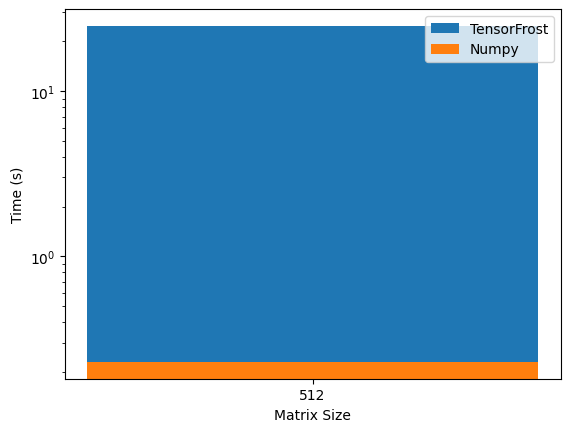

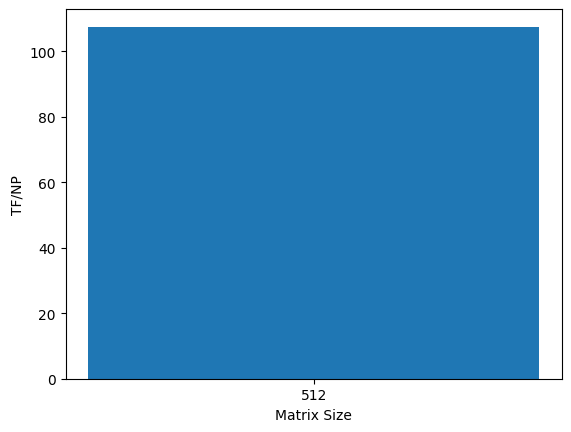

[24.72399926185608]
[0.23000049591064453]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)